# Summation of research
## A presentation on different approaches to clustering NFTRank data

This notebook will cover various topics including clustering algorithms and dimension reduction techniques via Python. The goal of this research is to mix different approaches of dimension reduction techniques with clustering algorithms (PCA with K-Means, or UMAP with DBSCAN) to prove that clustering NFTRank data is possible for SwapEase. Finding/creating a successful approach will give SwapEase a critical edge in the market. Such a process does not exist in the NFT space, and can be a powerful tool in a seasoned trader's hands. The summation of this research will help create descriptive enough data that will provide key insights for NFT arbitrage. 

I believe that clustering NFTs within a specific collection can help us achieve this. We can extract key information from "like NFTs" with efficient performance at scale. Information included could be anything from averages of trades to performance of clusters in the current market. This would be guided by the cluster since it reduces the scope of information to conglomerate.

In [32]:
import pandas

# The data file path used in this document
KOIN_path = "./data/KOIN.csv"
BAYC_path = "./data/BAYC.csv"
DOODLES_path = "./data/DOODLES.csv"

constants = [
    {
        'path': "./data/KOIN.csv",
        'name': "KOIN"
    },
     {
        'path': "./data/BAYC.csv",
        'name': "BAYC"
    },
     {
        'path': "./data/DOODLES.csv",
        'name': "DOODLES"
    },
]

# Function to retrieve and set data in a data frame
def retrieve_data_from_csv(path):
    df = pandas.read_csv(path, index_col='token_id')
    return df

def retrieve_data():
    data_frames = []

    for constant in constants:
        data_frames.append(retrieve_data_from_csv(constant['path']))

    return data_frames

NFT_dfs = retrieve_data()

We should scale the data first. Standardization is a process from statistics where you take a dataset (or a distribution) and transform it such that it is centered around zero and has a standard deviation of one.

In [33]:
from sklearn.preprocessing import StandardScaler

def scale_data():
    scaled_data_frames = []

    for df in NFT_dfs:
        scaled_data_frames.append(StandardScaler().fit_transform(df))

    return scaled_data_frames

# Scale data using StandardScaler
scaled_dfs = scale_data()

## UMAP Analysis

In [34]:
import umap
from sklearn.preprocessing import StandardScaler

def create_embeddings():
    embeddings = []

    for scaled_df in scaled_dfs:
        reducer = umap.UMAP()
        embeddings.append(reducer.fit_transform(scaled_df))

    return embeddings

embeddings = create_embeddings()

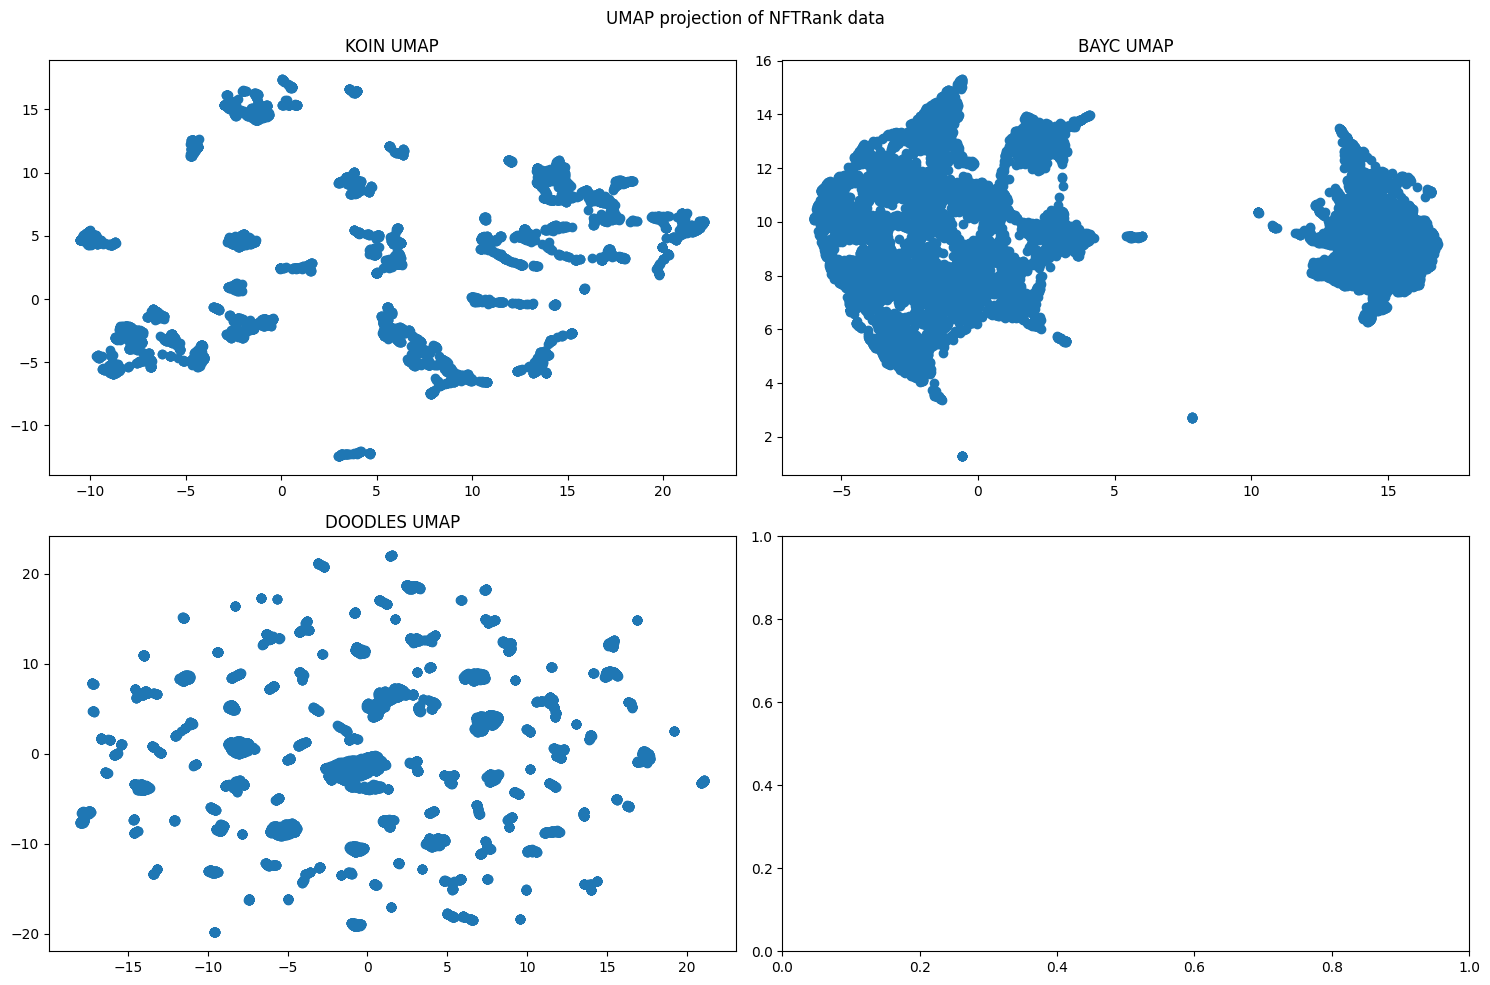

In [35]:
import matplotlib.pyplot as plt

def generate_UMAP_plots():
    fig, axs = plt.subplots(2,2, figsize=(15,10))
    
    fig.suptitle("UMAP projection of NFTRank data")

    axs[0,0].set_title("{} UMAP".format(constants[0]['name']))
    axs[0,0].scatter(embeddings[0][:, 0], embeddings[0][:, 1])

    axs[0,1].set_title("{} UMAP".format(constants[1]['name']))
    axs[0,1].scatter(embeddings[1][:, 0], embeddings[1][:, 1])

    axs[1,0].set_title("{} UMAP".format(constants[2]['name']))
    axs[1,0].scatter(embeddings[2][:, 0], embeddings[2][:, 1])

    fig.tight_layout()
    plt.show()

generate_UMAP_plots()

### Clustering using DBSCAN

In [36]:
from sklearn.cluster import DBSCAN

def get_DBSCAN_clusters():
    clusters = []

    for embedding in embeddings:
        clusterer_DBSCAN = DBSCAN(eps=.5)
        clusters.append(clusterer_DBSCAN.fit_predict(embedding))

    return clusters
        
UMAP_DBSCAN_clusters = get_DBSCAN_clusters()


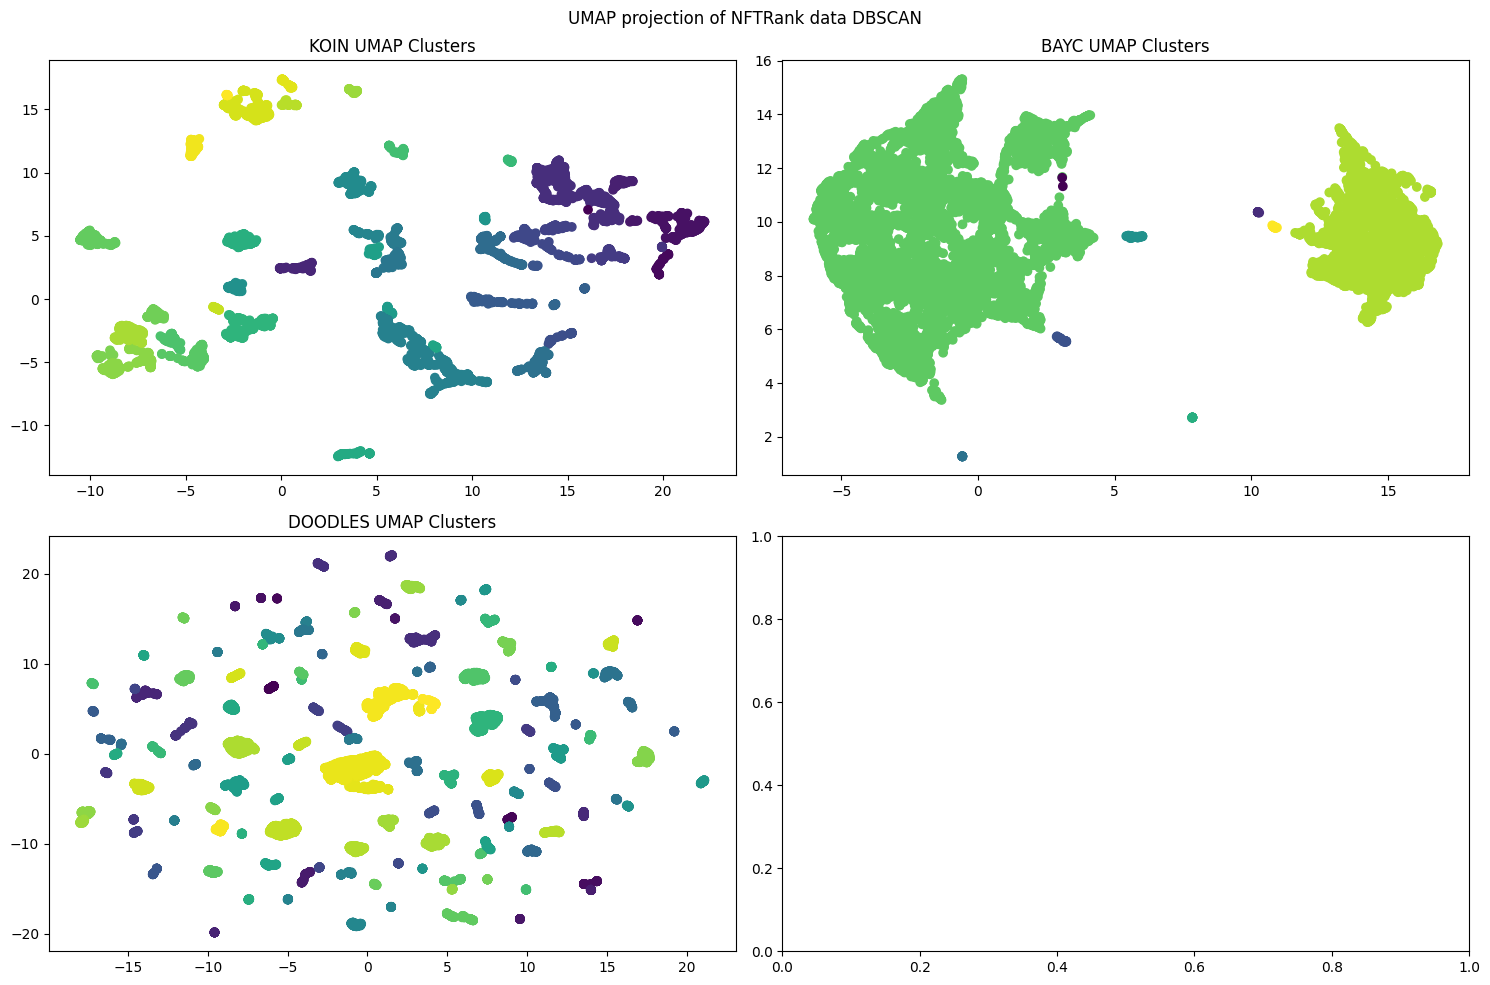

In [37]:
def generate_UMAP_cluster_plots(clusters, cluster_method_title):
    fig, axs = plt.subplots(2,2, figsize=(15,10))
    
    fig.suptitle("UMAP projection of NFTRank data {}".format(cluster_method_title))

    axs[0,0].set_title("{} UMAP Clusters".format(constants[0]['name']))
    axs[0,0].scatter(embeddings[0][:, 0], embeddings[0][:, 1], c=clusters[0])

    axs[0,1].set_title("{} UMAP Clusters".format(constants[1]['name']))
    axs[0,1].scatter(embeddings[1][:, 0], embeddings[1][:, 1], c=clusters[1])

    axs[1,0].set_title("{} UMAP Clusters".format(constants[2]['name']))
    axs[1,0].scatter(embeddings[2][:, 0], embeddings[2][:, 1], c=clusters[2])
    
    fig.tight_layout()
    plt.show()

generate_UMAP_cluster_plots(UMAP_DBSCAN_clusters, "DBSCAN")

To analyze these clusters, we need to ask specific questions:
- How many clusters are there?
- What is the average rank in a cluster?
- What is the average rank score in a cluster?
- What are the top 5 ranked NFTs in a cluster?

In [38]:
def get_clusters_dict(labels, data_frame):
    clusters_dict = {}

    for index, token_id in enumerate(data_frame.index):
        # Grab tha lable from the clusters array
        label = labels[index]
        token_information = {
            "token_id": token_id, 
            "rank": index + 1, 
            "token_information": data_frame.iloc[index].values
        }

        # Check if label is in dictionary
        if label in clusters_dict.keys():
            clusters_dict[label].append(token_information)
        else:
            clusters_dict[label] = [token_information]

    return clusters_dict

def analyze_clusters(clusters_dict):
    analysis = []
    rank_avg = []
    rank_sum_avg = []
    cluster_keys = clusters_dict.keys()
    # print('There are {} clusters'.format(len(cluster_keys)))

    for cluster_num in cluster_keys:
        rank_sum = 0
        rank_score_sum = 0
        token_ids = []
        ranks = []

        # print('Cluster {}'.format(cluster_num + 1))

        for token in clusters_dict[cluster_num]:
            rank_sum += token['rank']
            rank_score_sum += sum(token['token_information'])
            token_ids.append(token['token_id'])
            ranks.append(token['rank'])
        
        top_five = sorted(zip(ranks, token_ids), key=lambda t: t[0])[:5]

        analysis.append({
            "cluster_#": cluster_num + 1,
            "top_five": top_five
        })
        rank_avg.append(rank_sum/len(clusters_dict[cluster_num]))
        rank_sum_avg.append(rank_score_sum/len(clusters_dict[cluster_num]))

        # print('Average rank: {}'.format(rank_sum/len(clusters_dict[cluster_num])))
        # print('Average rank score: {}'.format(rank_score_sum/len(clusters_dict[cluster_num])))
        
        # print('Top 5: (Rank, Token_Id)')
        # for index in range(0, 5):
        #     print('\t {}, {}'.format(top_five[index][1], top_five[index][0]))

        # print('\n')

    avg_df = pandas.DataFrame({"Rank Avg": rank_avg, "Rank Sum Avg": rank_sum_avg}, columns = ['Rank Avg', 'Rank Sum Avg'])

    return {"analysis": analysis, "avg_df": avg_df}

def get_analysis(clusters):
    KOIN_clusters_dict = get_clusters_dict(clusters[0], NFT_dfs[0])
    BAYC_clusters_dict = get_clusters_dict(clusters[1], NFT_dfs[1])
    DOODLES_clusters_dict = get_clusters_dict(clusters[2], NFT_dfs[2])

    KOIN_analysis = analyze_clusters(KOIN_clusters_dict)
    BAYC_analysis = analyze_clusters(BAYC_clusters_dict)
    DOODLES_analysis = analyze_clusters(DOODLES_clusters_dict)

    return [KOIN_analysis, BAYC_analysis, DOODLES_analysis]

In [39]:
analysis = get_analysis(UMAP_DBSCAN_clusters)

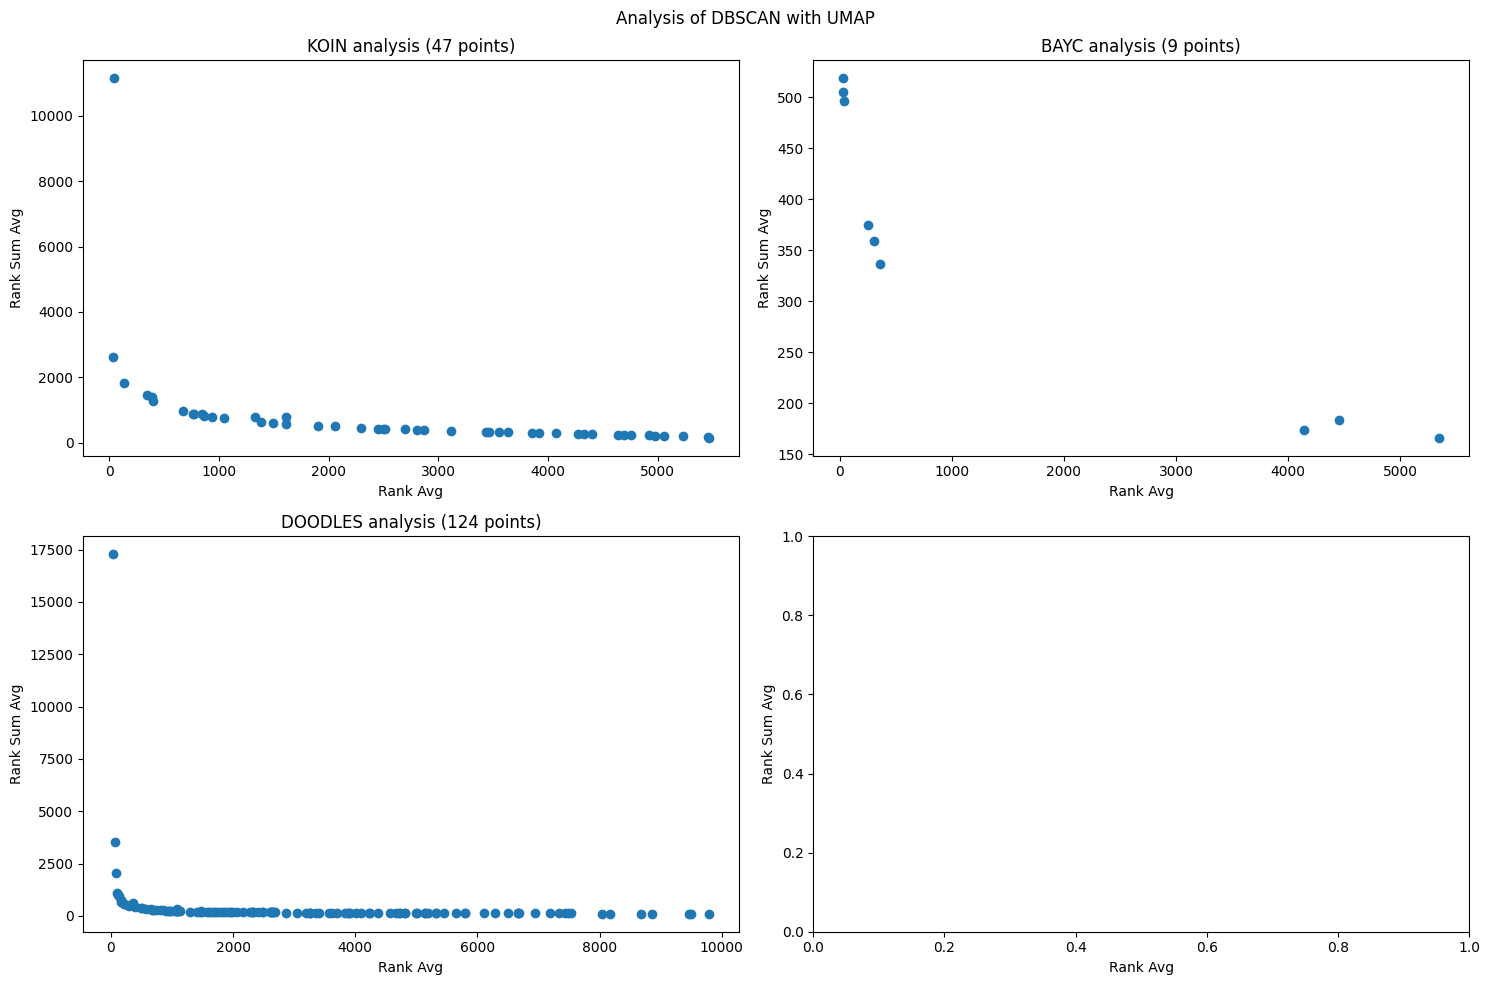

In [42]:
def generate_analysis_plot(analysis, cluster_method_title):
    fig, axs = plt.subplots(2,2, figsize=(15,10))
    
    fig.suptitle("Analysis of {}".format(cluster_method_title))

    axs[0,0].set_title("{} analysis ({} points)".format(constants[0]['name'],len(analysis[0]['avg_df'])))
    axs[0,0].scatter(x=analysis[0]['avg_df']['Rank Avg'], y=analysis[0]['avg_df']['Rank Sum Avg'])

    axs[0,1].set_title("{} analysis ({} points)".format(constants[1]['name'],len(analysis[1]['avg_df'])))
    axs[0,1].scatter(x=analysis[1]['avg_df']['Rank Avg'], y=analysis[1]['avg_df']['Rank Sum Avg'])

    axs[1,0].set_title("{} analysis ({} points)".format(constants[2]['name'],len(analysis[2]['avg_df'])))
    axs[1,0].scatter(x=analysis[2]['avg_df']['Rank Avg'], y=analysis[2]['avg_df']['Rank Sum Avg'])

    for ax in axs.flat:
        ax.set(xlabel='Rank Avg', ylabel='Rank Sum Avg')

    fig.tight_layout()
    plt.show()
    
generate_analysis_plot(analysis, "DBSCAN with UMAP")
# plt.scatter(x=rank_analysis["Rank Avg"], y=rank_analysis['Rank Sum Avg'])
# plt.title("DBSCAN using UMAP rank analysis")

We can see some desirable outcomes here. First thing to note are the points that exist near the 0 range of Rank Avg. What this tells us, is that there are clusters that have high ranks that were grouped together. We can confirm this by where they are placed on the Rank Sum Avg. High ranking NFTs will have high scores. 

The BAYC analysis, in particular, is a model example of the outcome we want to achieve. There is a clear high, middle, and low based on how the points look on the graph. Something that could bite us in the end

### Clustering using KMEAN

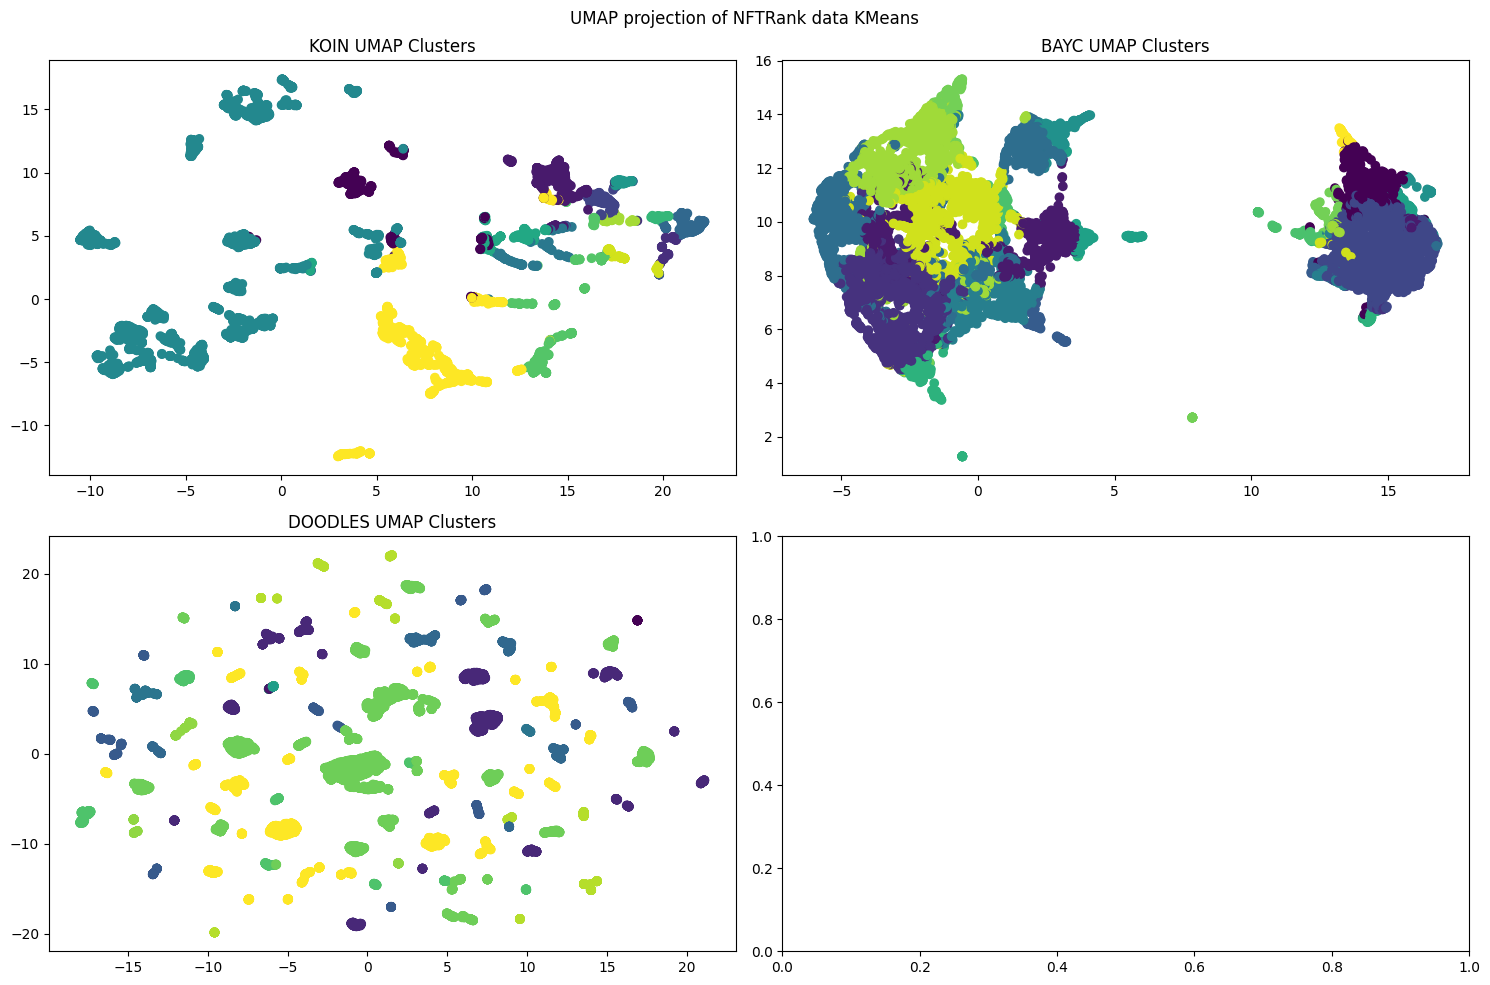

In [41]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns

kmeans_kwargs = {
    "init": "random",
    "n_init": 50,
    "max_iter": 500,
}

def get_KMEAN_labels():
    kmeans_labels = []

    for scaled_df in scaled_dfs:
        best_score = -1
        labels = 0

        for k in range(15, 25):
            kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
            kmeans.fit(scaled_df)
            score = silhouette_score(scaled_df, kmeans.labels_)

            if score > best_score:
                best_score = score
                labels = kmeans.labels_

        kmeans_labels.append(labels)

    return kmeans_labels

labels = get_KMEAN_labels()

generate_UMAP_cluster_plots(labels, "KMeans")

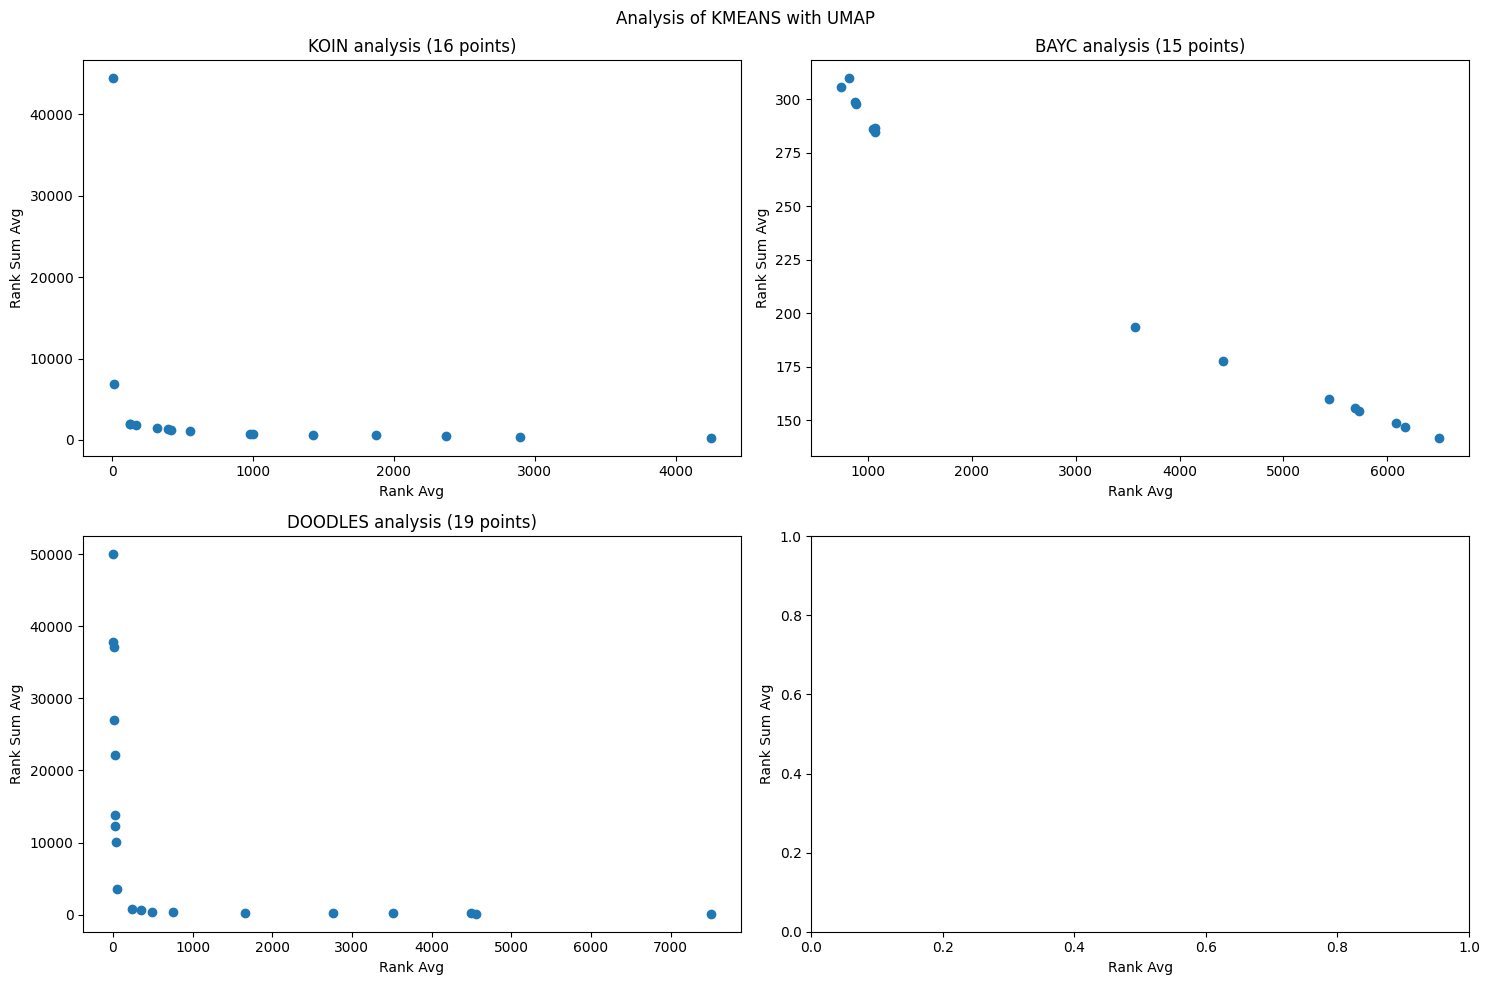

In [43]:
analysis = get_analysis(labels)
generate_analysis_plot(analysis, "KMEANS with UMAP")

### Clustering using Agglomerative Clustering

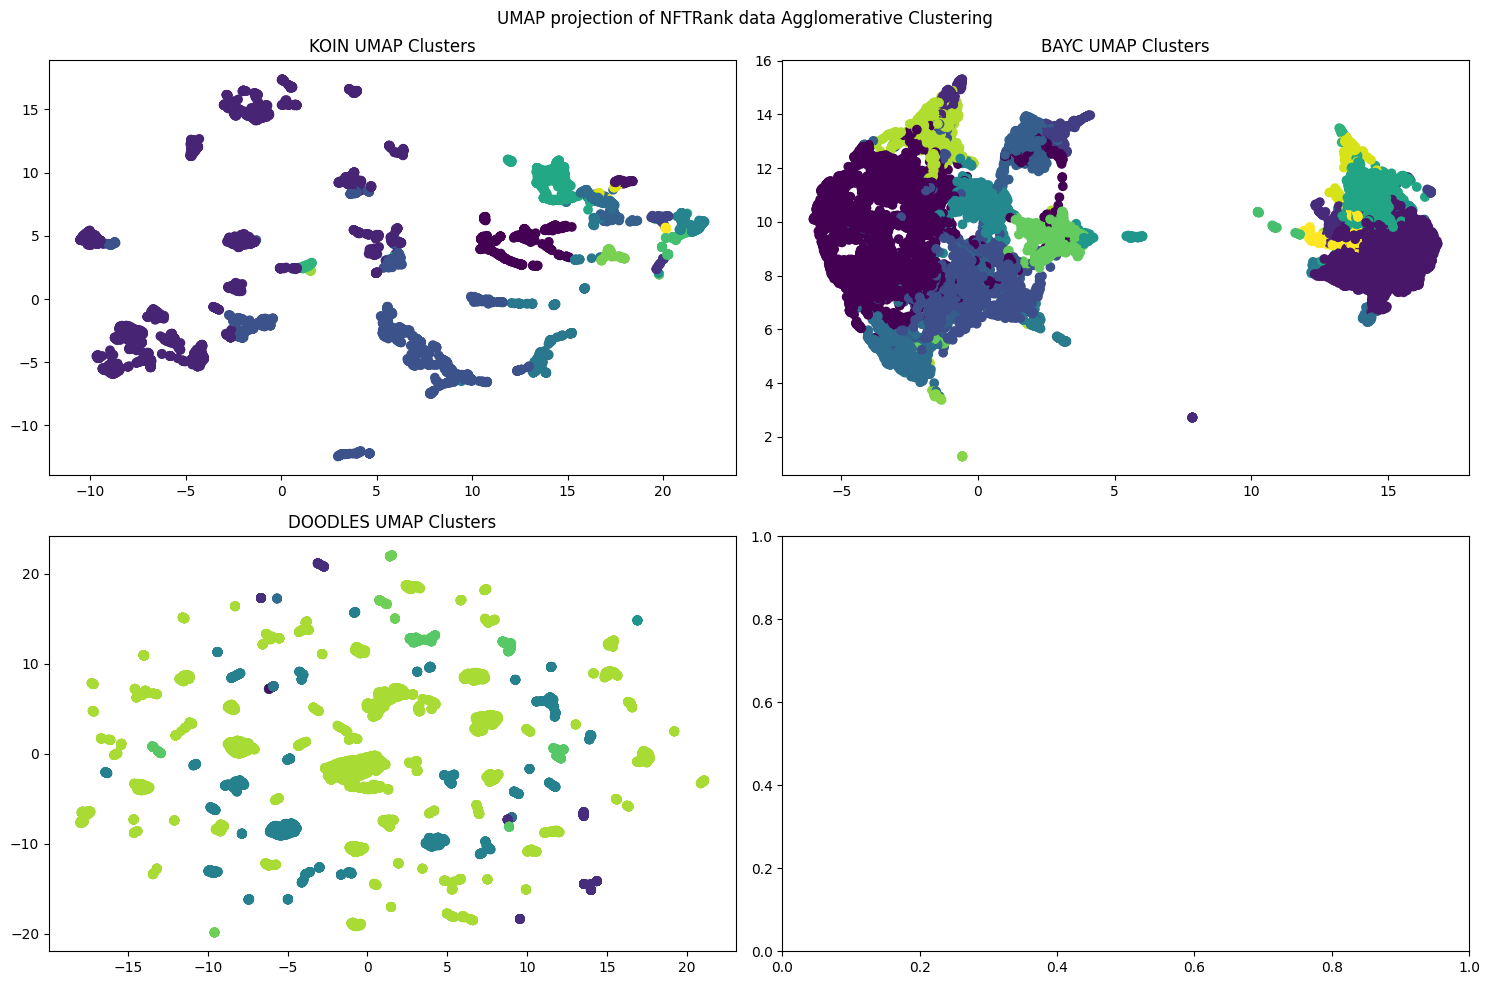

In [44]:
from sklearn.cluster import AgglomerativeClustering

def get_Agglomerative_labels():
    agglomerative_labels = []

    for scaled_df in scaled_dfs:
        best_score = -1
        labels = 0

        for k in range(15, 25):
            agglomerative_model = AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='ward')
            agglomerative_model.fit(scaled_df)
            score = silhouette_score(scaled_df, agglomerative_model.labels_)

            if score > best_score:
                best_score = score
                labels = agglomerative_model.labels_

        agglomerative_labels.append(labels)

    return agglomerative_labels

agglomerative_labels = get_Agglomerative_labels()
generate_UMAP_cluster_plots(agglomerative_labels, "Agglomerative Clustering")

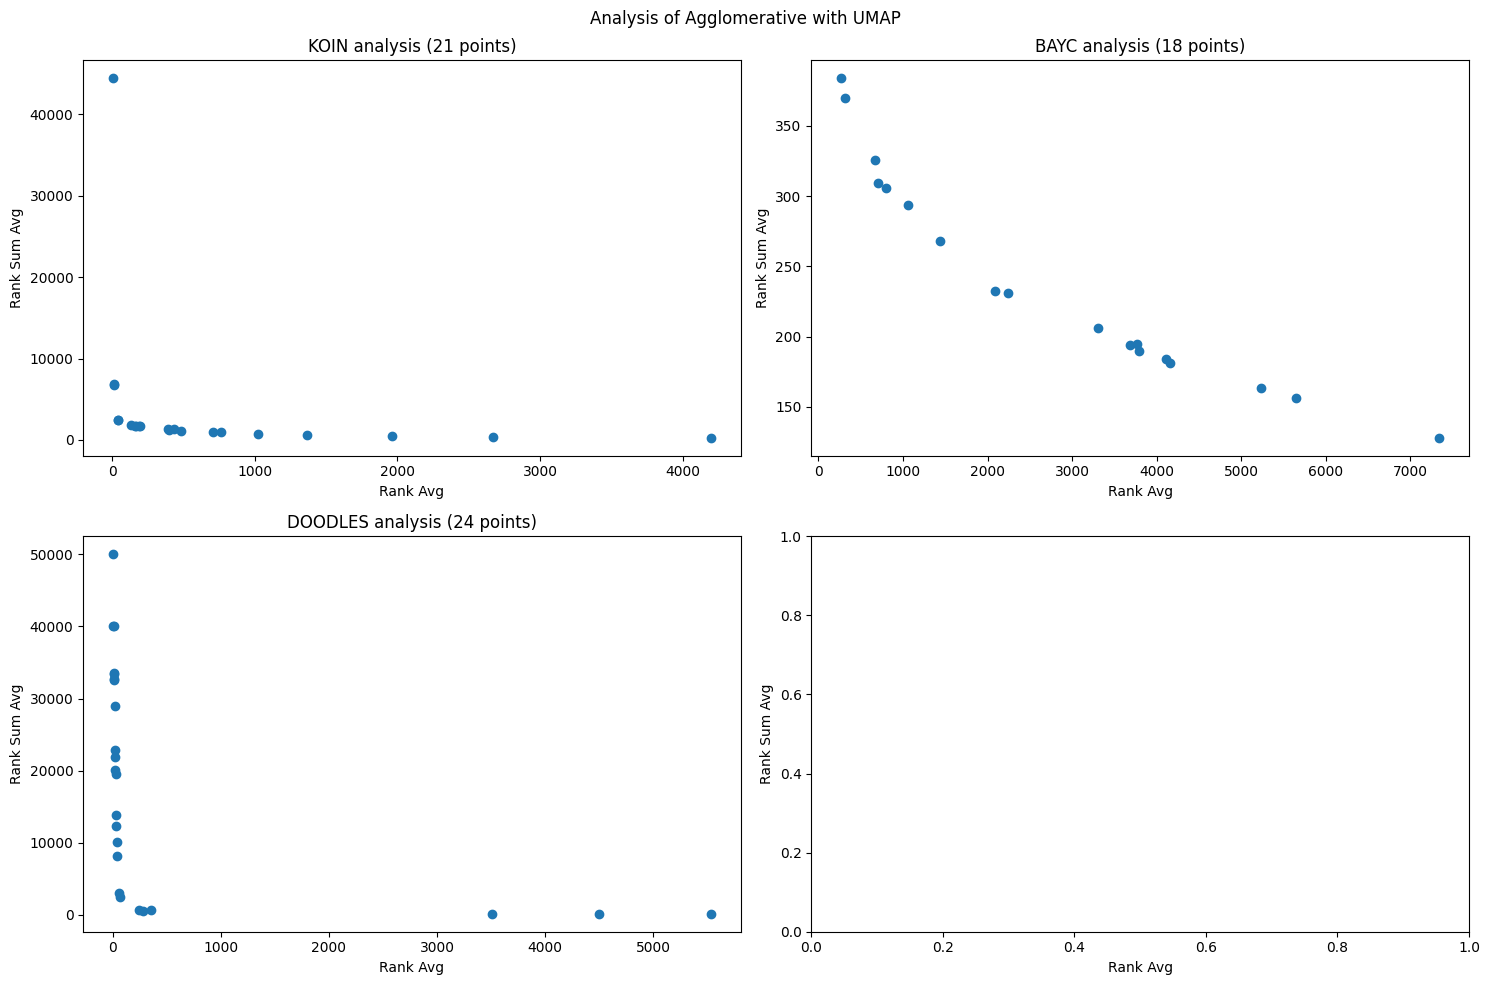

In [45]:
analysis = get_analysis(agglomerative_labels)
generate_analysis_plot(analysis, "Agglomerative with UMAP")